## Vehicle Detection and Tracking

### Imports

In [1]:
# http://www.numpy.org/
import numpy as np

# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html
import cv2

# http://matplotlib.org/
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# http://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html
from mpl_toolkits.mplot3d import Axes3D

# http://scikit-image.org/docs/dev/api/skimage.feature.html
from skimage.feature import hog

# http://scikit-learn.org/stable/modules/preprocessing.html
from sklearn.preprocessing import StandardScaler

# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
from sklearn.model_selection import train_test_split

# http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
from sklearn.svm import LinearSVC

# https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.ndimage.measurements.label.html
from scipy.ndimage.measurements import label

# https://docs.python.org/2/library/pickle.html
import pickle

# https://docs.python.org/2/library/glob.html
import glob

# https://docs.python.org/3/library/random.html#random.shuffle
from random import shuffle

# https://docs.python.org/2/library/os.html
import os

# https://docs.python.org/2/library/time.html
import time

# https://docs.python.org/2/library/math.html
import math

# https://pypi.python.org/pypi/tqdm
from tqdm import tqdm

# http://zulko.github.io/moviepy/
from moviepy.editor import VideoFileClip

### Section I: Camera Calibration and Distortion Correction

##### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/calibration*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

##### Apply a distortion correction to raw images.

In [3]:
img = cv2.imread('camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("camera_cal/dist_pickle.p", "wb"));

##### Unwarp corners and visualize resulting images.

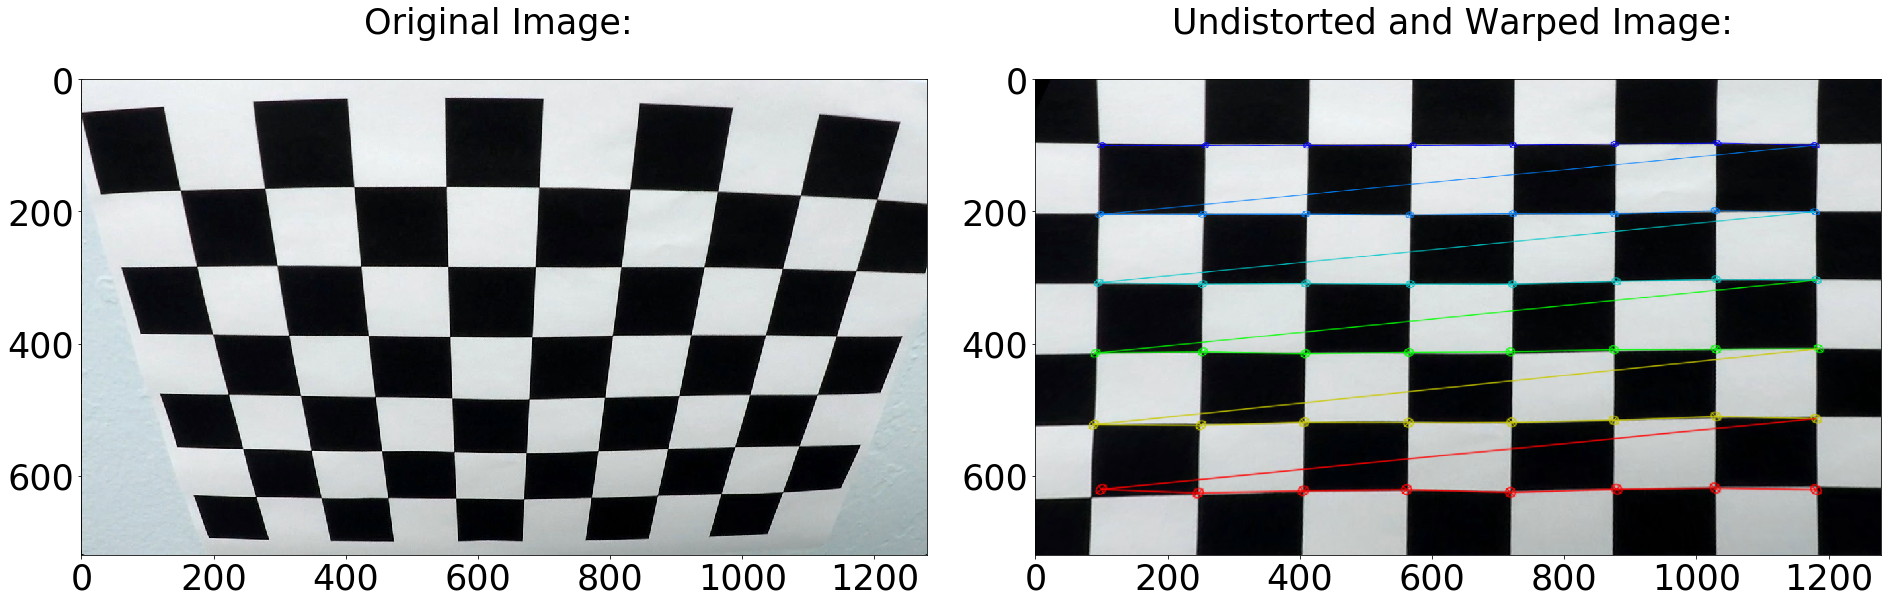

In [5]:
dist_pickle = pickle.load( open( "camera_cal/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = cv2.imread('camera_cal/calibration2.jpg')
nx = 8
ny = 6
def corners_unwarp(img, nx=nx, ny=ny, mtx=mtx, dist=dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        offset = 100
        img_size = (gray.shape[1], gray.shape[0])
        src = np.float32([corners[0],
                          corners[nx-1],
                          corners[-1],
                          corners[-nx]])
        dst = np.float32([[offset, offset],
                          [img_size[0]-offset, offset],
                          [img_size[0]-offset, img_size[1]-offset], 
                          [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
f.tight_layout()

matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

ax1.imshow(img)
ax1.set_title('Original Image: \n', fontsize=35)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image: \n', fontsize=35)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/undistorted_and_warped.png', bbox_inches="tight")

In [6]:
def plotter(test_img, new_img, plot_title=None, n=0):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,7.2))
    f.tight_layout()
    ax1.imshow(test_img)
    ax1.set_title('Original Image:', fontsize=15)
    ax2.imshow(new_img, cmap='gray')
    ax2.set_title('{0}:'.format(plot_title, n+1), fontsize=15)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
def pipeline(op=None):
    test_images = glob.glob('test_images/test*.jpg')
    n = 0
    for img in test_images:
        img = cv2.imread(img)
        test_img = bgr_to_rgb(img)
        if op == 'Undistorted Image':
            new_img = undistort(img)
            plotter(test_img, cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB), op, n)
            matplotlib.rc('xtick', labelsize=15) 
            matplotlib.rc('ytick', labelsize=15)
            plt.savefig('output_images/undistorted.png'.format(op), bbox_inches="tight")
            break
        if op == 'Sobel X':
            new_img = undistort(img)
            new_img = sobel_x(img)
            plotter(test_img, new_img, op, n)
            plt.savefig('output_images/sobel_x.png'.format(op), bbox_inches="tight")
            break
        n += 1

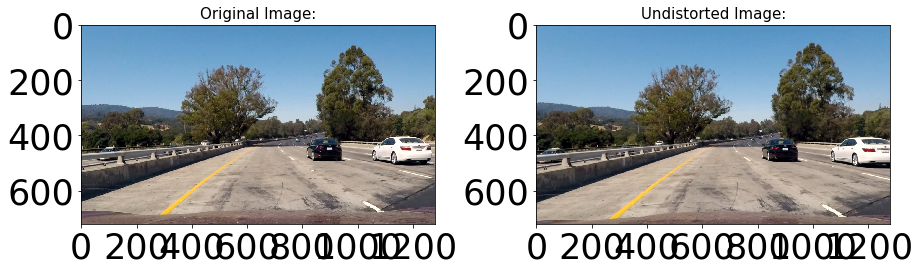

In [7]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def undistort(img):
    mtx = dist_pickle['mtx']
    dist = dist_pickle['dist']
    return cv2.undistort(img, mtx, dist, None, mtx)            

pipeline(op='Undistorted Image')

### Section II: Feature Extraction and Training with a Linear SVM Classifier

##### Visualize the data set.

Total Number of Car Images: 2826
Total Number of Non-Car Images: 8968
Image Size: (64, 64, 3)
Image Type: float32


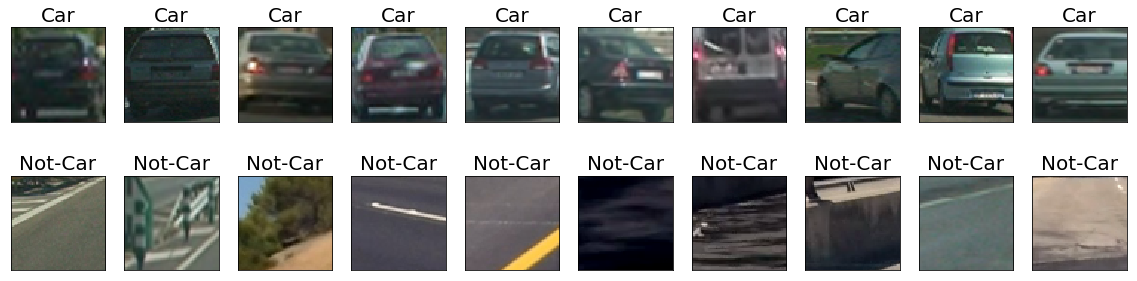

In [8]:
cars_far = glob.glob('datasets/vehicles/GTI_Far/image*.png')
cars_left = glob.glob('datasets/vehicles/GTI_Left/image*.png')
cars_middle = glob.glob('datasets/vehicles/GTI_MiddleClose/image*.png')
cars_right = glob.glob('datasets/vehicles/GTI_Right/image*.png')
cars = cars_far + cars_left + cars_middle + cars_right
shuffle(cars)

not_cars_extras = glob.glob('datasets/non-vehicles/Extras/extra*.png')
not_cars_gti = glob.glob('datasets/non-vehicles/GTI/image*.png')
not_cars = not_cars_extras + not_cars_gti
shuffle(not_cars)

def visualize_data(cars, not_cars):
    data_dict = {}
    data_dict["n_cars"] = len(cars)
    data_dict["n_not_cars"] = len(not_cars)
    img = mpimg.imread(cars[0])
    data_dict["img_shape"] = img.shape
    data_dict["d_type"] = img.dtype
    return data_dict

visual = visualize_data(cars, not_cars)

print('Total Number of Car Images: {0}'.format(visual['n_cars']))
print('Total Number of Non-Car Images: {0}'.format(visual['n_not_cars']))

print('Image Size: {0}\nImage Type: {1}'.format(visual['img_shape'], visual['d_type']))

def random_image(cars, not_cars):
    car_id = np.random.randint(0, len(cars))
    not_car_id = np.random.randint(0, len(not_cars))
    car_image = mpimg.imread(cars[car_id])
    not_car_image = mpimg.imread(not_cars[not_car_id])
    return car_image, not_car_image

n = 0
fig = plt.figure(figsize=(20, 10))
while n < 10:
    car_image, not_car_image = random_image(cars, not_cars)
    fig.add_subplot(1, 10, n+1)
    plt.imshow(not_car_image)
    plt.xticks(()); plt.yticks(());    
    plt.title('Not-Car', fontsize=20)
    fig.add_subplot(2, 10, n+1)
    plt.imshow(car_image)
    plt.xticks(()); plt.yticks(());    
    plt.title('Car', fontsize=20)
    n += 1
plt.savefig('output_images/data_visualization.png', bbox_inches="tight")

##### Randomly select an image for visualization.

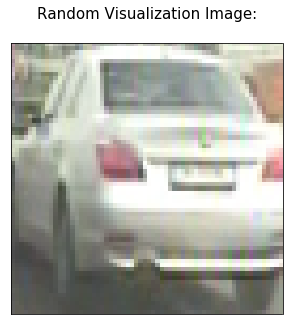

In [9]:
car_id = np.random.randint(0, len(cars))
rand_img = cv2.imread(cars[car_id])
rand_img = cv2.cvtColor(rand_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.imshow(rand_img);
plt.title('Random Visualization Image:\n', fontsize=15)
plt.xticks(()); plt.yticks(());
plt.savefig('output_images/random_image_visualization.png', 
            bbox_inches="tight")

##### Visualize histograms of color in an image.

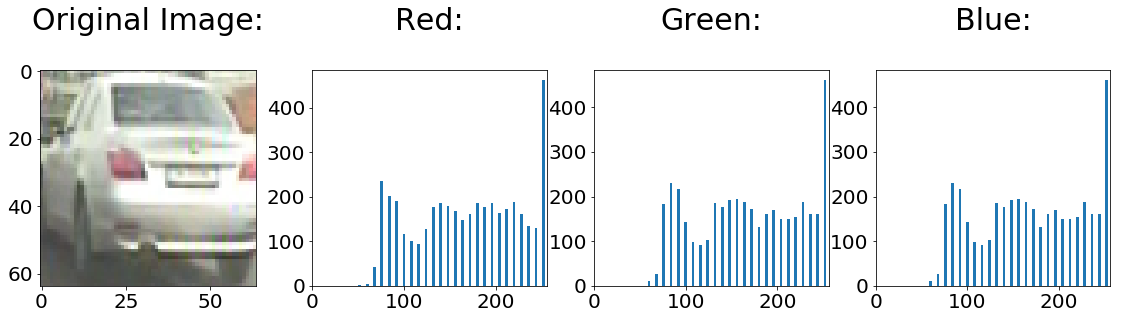

In [10]:
red_hist = np.histogram(rand_img[:,:,0], bins=32, range=(0, 256))
green_hist = np.histogram(rand_img[:,:,1], bins=32, range=(0, 256))
blue_hist = np.histogram(rand_img[:,:,1], bins=32, range=(0, 256))
hist_features = np.concatenate((red_hist[0], green_hist[0], blue_hist[0]))

bin_edges = red_hist[1] #all three bins are the same size
bin_centers = (bin_edges[1:] + bin_edges[00:len(bin_edges) - 1])/2

fig = plt.figure(figsize=(10,3));
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

plt.subplot(1, 4, 1)
plt.imshow(rand_img)
plt.title('Original Image:\n', fontsize=30);

plt.subplot(1, 4, 2)
plt.bar(bin_centers, red_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Red:\n', fontsize=30);

plt.subplot(1, 4, 3)
plt.bar(bin_centers, green_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Green:\n', fontsize=30);

plt.subplot(1, 4, 4)
plt.bar(bin_centers, blue_hist[0], width=3)
plt.xlim(0, 256)
plt.title('Blue:\n', fontsize=30);

plt.subplots_adjust(left=0.5, right=2, top=1, bottom=0.)
plt.savefig('output_images/color_histograms_visualization.png', 
            bbox_inches="tight")

##### Visualize the distribution of color in an image.

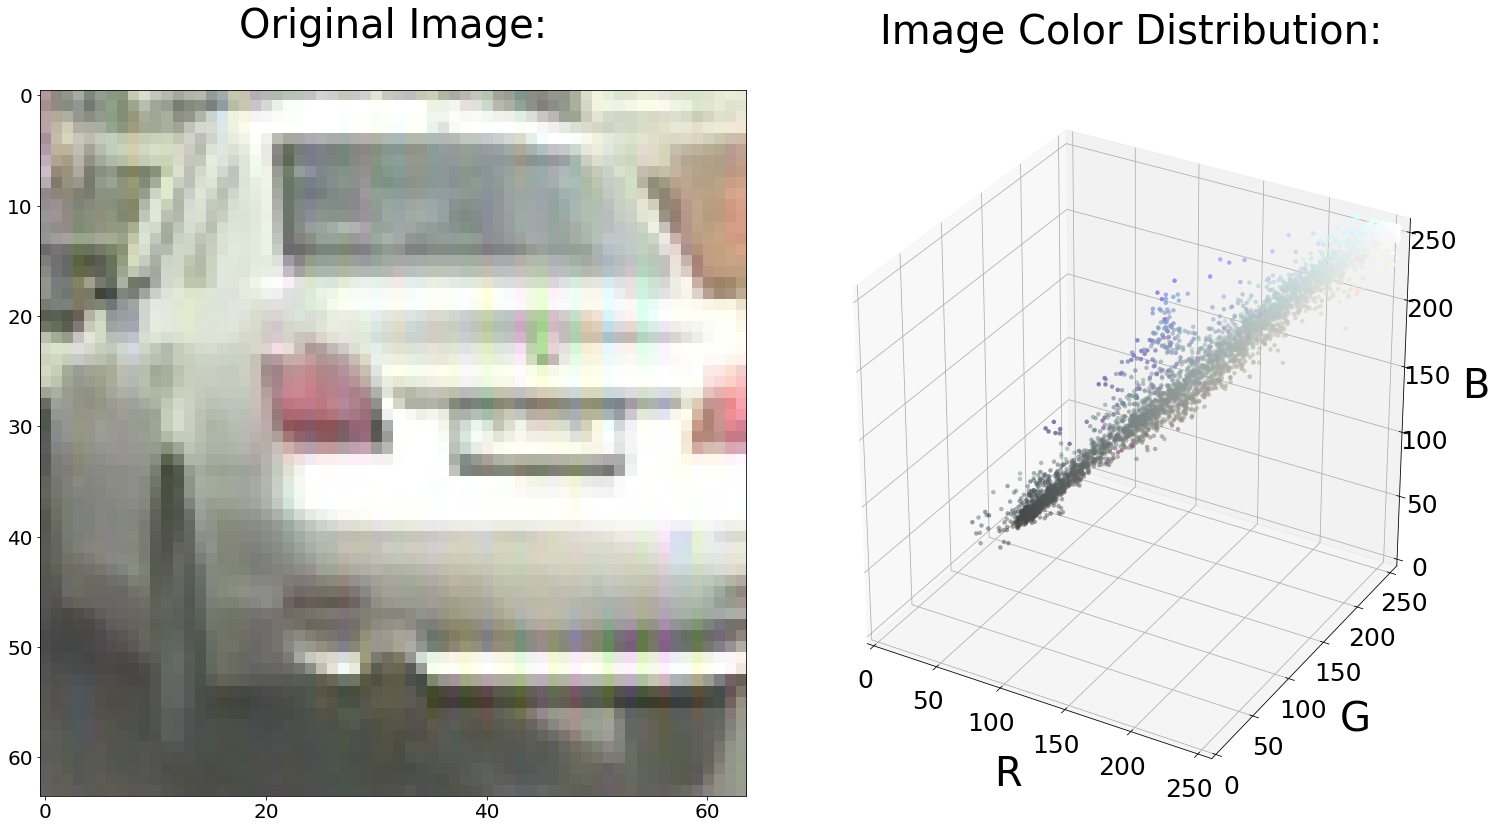

In [11]:
scale = max(rand_img.shape[0], rand_img.shape[1], 64) / 64
img_small = cv2.resize(rand_img, (np.int(rand_img.shape[1] / scale), 
                                  np.int(rand_img.shape[0] / scale)), 
                                  interpolation=cv2.INTER_NEAREST)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.

pixels = img_small_RGB
colors_rgb = img_small_rgb
axis_labels = list('RGB')
axis_limits = [(0,255), (0,255), (0,255)]

f = plt.figure(figsize=(20,10));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=40) 
matplotlib.rc('ytick', labelsize=40)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=40);

ax2 = f.add_subplot(1, 2, 2, projection='3d');
ax2.text2D(0.15, 0.99, "Image Color Distribution:\n", 
           transform=ax2.transAxes, fontsize=40)

ax2.set_xlim(*axis_limits[0])
ax2.set_ylim(*axis_limits[1])
ax2.set_zlim(*axis_limits[2])

ax2.tick_params(axis='both', which='major', labelsize=25, pad=8)
ax2.set_xlabel(axis_labels[0], fontsize=40, labelpad=30)
ax2.set_ylabel(axis_labels[1], fontsize=40, labelpad=30)
ax2.set_zlabel(axis_labels[2], fontsize=40, labelpad=30)

ax2.scatter(pixels[:,:,0].ravel(), pixels[:,:,1].ravel(), 
            pixels[:,:,2].ravel(), c=colors_rgb.reshape((-1, 3)), 
            edgecolors='none');

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/color_distribution_visualization.png', 
            bbox_inches="tight")

##### Visualize the spatial binning of color in an image.

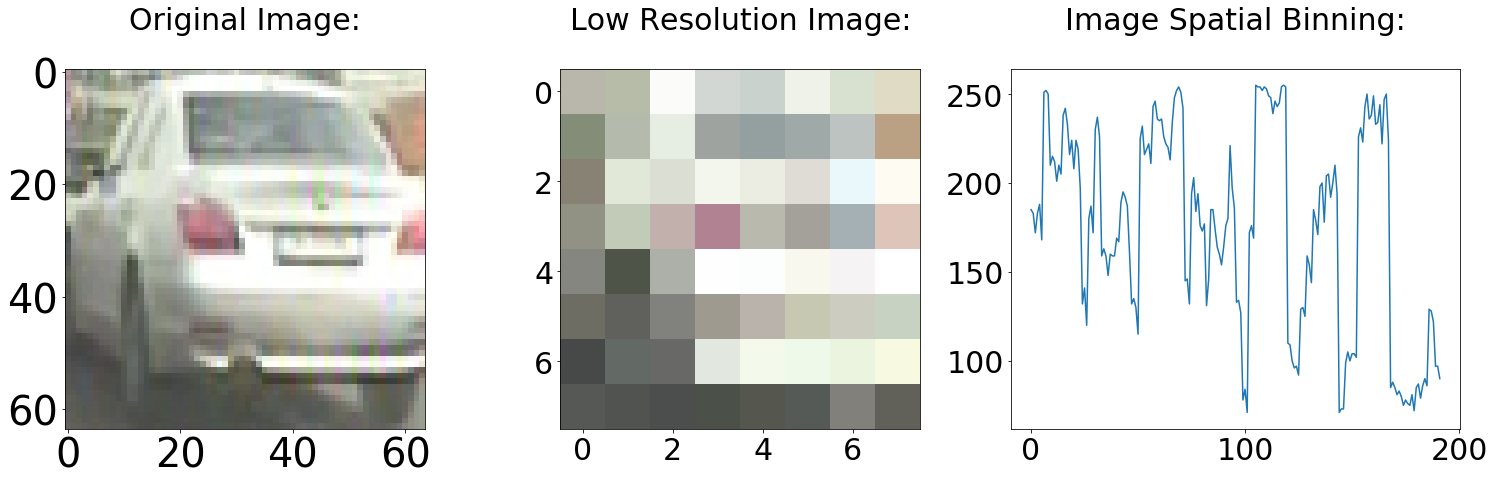

In [12]:
color_space = 'RGB'
size = (8, 8)

small_img = cv2.resize(rand_img, size)

if color_space != 'RGB':
    if color_space == 'HSV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2HSV)
    elif color_space == 'LUV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2LUV)
    elif color_space == 'HLS':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2HLS)
    elif color_space == 'YUV':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2YUV)
    elif color_space == 'YCrCb':
        feature_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2YCrCb)
else: 
    feature_img = np.copy(rand_img)             
features = cv2.resize(feature_img, size).ravel() 

f = plt.figure(figsize=(20, 5));
ax1 = f.add_subplot(1, 3, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=30);

ax2 = f.add_subplot(1, 3, 2);
ax2.imshow(small_img)
ax2.set_title('Low Resolution Image:\n', fontsize=30);

ax3 = f.add_subplot(1, 3, 3);
ax3.plot(features)
ax3.set_title('Image Spatial Binning:\n', fontsize=30);

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/spatial_binning_visualization.png', 
            bbox_inches="tight")

##### Visualize gradient features in an image.

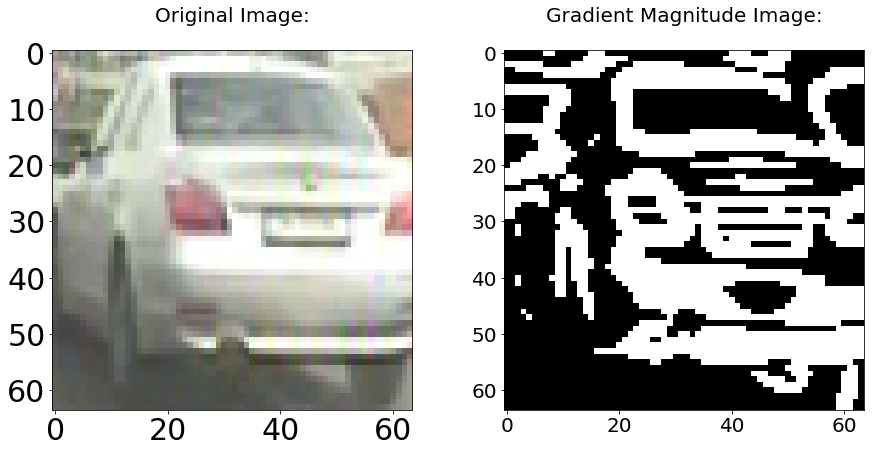

In [13]:
gray = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)
sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=9)
sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=9)
gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
scale_factor = np.max(gradmag)/255 
gradmag = (gradmag/scale_factor).astype(np.uint8) 
binary_output = np.zeros_like(gradmag)
binary_output[(gradmag >= 50) & (gradmag <= 255)] = 1

f = plt.figure(figsize=(12, 5));
ax1 = f.add_subplot(1, 2, 1);
f.tight_layout()
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
ax1.imshow(rand_img)
ax1.set_title('Original Image:\n', fontsize=20);

ax2 = f.add_subplot(1, 2, 2);
ax2.imshow(binary_output, cmap='gray')
ax2.set_title('Gradient Magnitude Image:\n', fontsize=20);

plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)
plt.savefig('output_images/gradient_visualization.png', 
            bbox_inches="tight")

##### Visualize HOG features in an image.

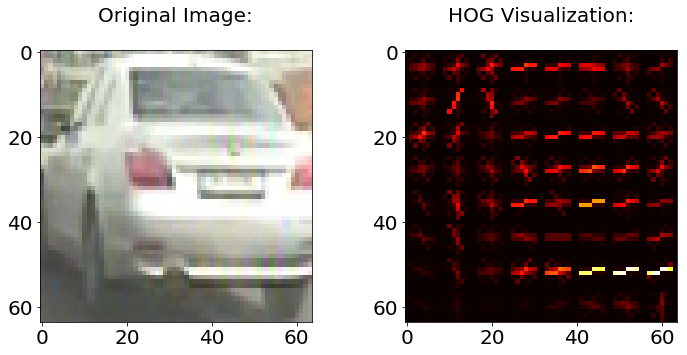

In [14]:
from skimage.feature import hog

hog_img = cv2.cvtColor(rand_img, cv2.COLOR_RGB2GRAY)

features, hog_image = hog(hog_img, 
                          orientations=9, 
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualise=True,
                          feature_vector=False)

fig = plt.figure(figsize=(12, 5));
fig.add_subplot(1, 2, 1)
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.imshow(rand_img)
plt.title('Original Image:\n', fontsize=20);
fig.add_subplot(1, 2, 2)
plt.imshow(hog_image, cmap='hot')
plt.title('HOG Visualization:\n', fontsize=20);
plt.savefig('output_images/hog_visualization.png', 
            bbox_inches="tight")

##### Combine feature extraction methods and apply to the labeled training set.

In [15]:
def get_color_histogram(img, n_bins=32, bins_range=(0, 256)):
    red_hist = np.histogram(img[:,:,0], bins=n_bins, range=bins_range)
    green_hist = np.histogram(img[:,:,1], bins=n_bins, range=bins_range)
    blue_hist = np.histogram(img[:,:,2], bins=n_bins, range=bins_range)
    bin_edges = red_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((red_hist[0], 
                                    green_hist[0], 
                                    blue_hist[0]))
    return red_hist, green_hist, blue_hist, bin_centers, hist_features

def get_3d_color_plot(pixels, colors_rgb,
                      axis_labels=list("RGB"),
                      axis_limits=[(0, 255), (0, 255), (0, 255)]):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)  
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax

def get_bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

def get_gradient_features(img, sobel_kernel=9, mag_threshold=(60, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & \
                  (gradmag <= mag_threshold[1])] = 1
    return binary_output

def get_hog_features(img, 
                     orientation=9, 
                     pixels_per_cell=(8,8), 
                     cells_per_block=(2,2), 
                     visualization=False, 
                     feature_vector=True):
    if visualization == True:
        features, hog_image = hog(img, orientations=orientation, 
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, 
                                  transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orientation, 
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, 
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector) 
        return features
    
def extract_features(images, color_space='RGB', 
                     spatial_size=(32,32), 
                     hist_bins=32, hist_range=(0,256),
                     orientations=9, pixels_per_cell=(8,8),
                     cells_per_block=(2,2), hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)      
        
        if spatial_feat == True:
            spatial_features = get_bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pixels_per_cell, 
                                                         cells_per_block, visualization=False,
                                                         feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orientations, pixels_per_cell,
                                                cells_per_block, visualization=False,
                                                feature_vector=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))      
    return features

##### Classify by color.

100%|██████████| 8968/8968 [00:19<00:00, 449.46it/s]


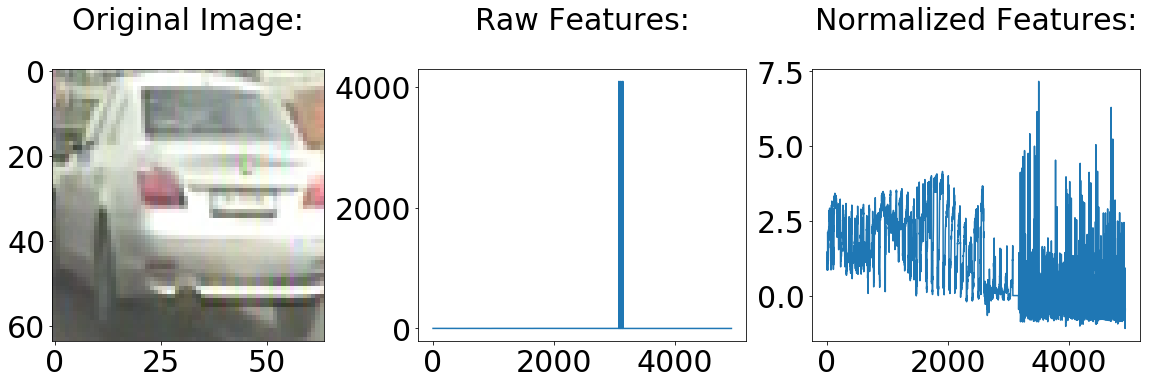

In [16]:
car_features = extract_features(cars, spatial_feat=True, hist_feat=True)
not_car_features = extract_features(not_cars, spatial_feat=True, hist_feat=True)

if len(car_features) > 0:
    X = np.vstack((car_features, not_car_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/color_classification.png')

else:
    print('Returned empty feature vectors.')

##### Define a labels vector based on feature lists.

In [17]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

X = np.vstack((car_features, not_car_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
print('Done.')

Done.


##### Shuffle and split normalized feature data into training, validation, and testing sets.

In [18]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
print('Done.')

Done.


##### Train a Linear SVM classifier to classify by color.

In [19]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

12.92 seconds to train SVC.


##### Check the accuracy of the color classification.

In [20]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])

Test Accuracy: 97.8381%
  Predictions: [ 0.  1.  0.  1.  1.  1.  0.  0.  1.  0.]
       Labels: [ 0.  1.  0.  1.  1.  1.  0.  0.  1.  0.]


##### Classify by HOG.

100%|██████████| 8968/8968 [00:15<00:00, 594.65it/s]


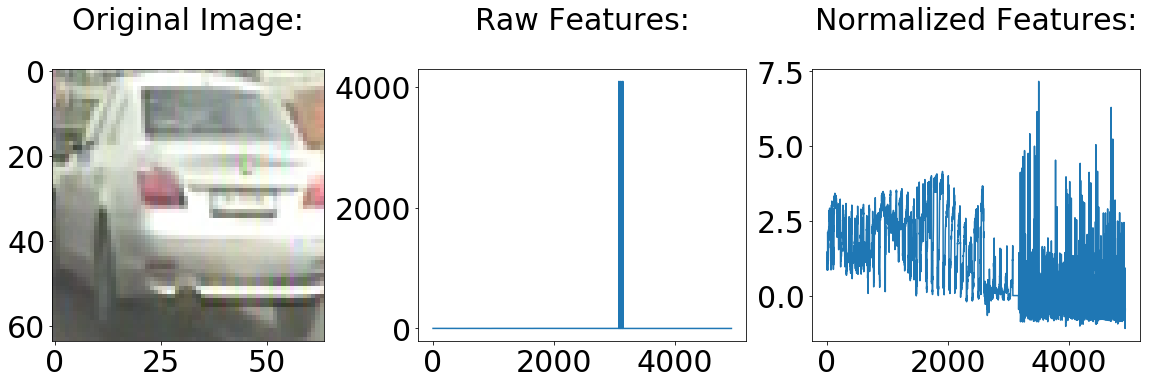

In [21]:
car_features = extract_features(cars, hog_feat=True)
not_car_features = extract_features(not_cars, hog_feat=True)

if len(car_features) > 0:
    X = np.vstack((car_features, not_car_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/hog_classification.png')

else:
    print('Returned empty feature vectors.')

##### Define a labels vector based on feature lists.

In [22]:
y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

X = np.vstack((car_features, not_car_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
print('Done.')

Done.


##### Shuffle and split normalized feature data into training, validation, and testing sets.

In [23]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y,
                                                    test_size=0.2,
                                                    random_state=rand_state)
print('Done.')

Done.


##### Train a Linear SVM classifier to classify by HOG.

In [24]:
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

12.23 seconds to train SVC.


##### Check the accuracy of the HOG classification.

In [25]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

Test Accuracy: 97.7533%
  Predictions: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
       Labels: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
0.00179 seconds to predict 10 labels with SVC.


### Section III: Search for Vehicles in Images 

##### Implement a sliding-window technique to filter the image for possible vehicles.

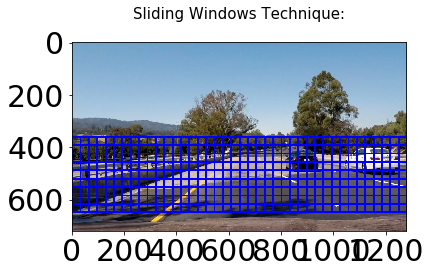

In [26]:
def draw_boxes(img, bboxes, color=(0,0,255), thickness=6):
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], 
                      color, thickness)
    return img_copy

def sliding_windows(img, x_start_stop=[None,None], 
                    y_start_stop=[None,None], xy_window=(64,64),
                    xy_overlap=(0.5,0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*0.5)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*0.9)
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list

test_img = mpimg.imread('test_images/test4.jpg')

windows =  sliding_windows(test_img)

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:\n', fontsize=15);
plt.savefig('output_images/sliding_windows.png')

##### Apply trained classifier to search for vehicles in sliding-window images.

100%|██████████| 8968/8968 [00:20<00:00, 445.01it/s]


Using: 9 orientations (16, 16) pixels per cell and (4, 4) cells per block
Feature vector length: 1248
1.77  seconds to train SVC.
Test Accuracy of SVC: 98.1348%


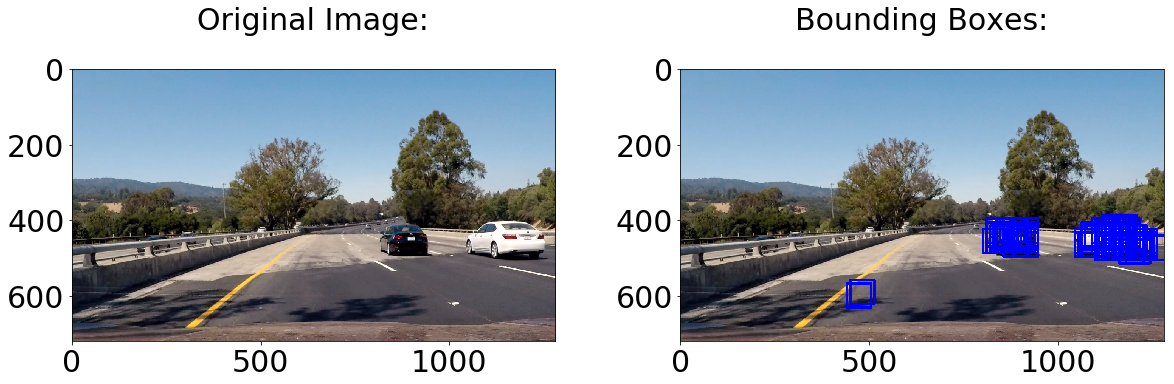

In [27]:
def single_img_features(img, color_space='RGB', 
                        spatial_size=(64,64), hist_bins=64, 
                        orientations=9, pixels_per_cell=(8,8), 
                        cells_per_block=(2,2), hog_channel=0, 
                        spatial_feat=True, hist_feat=True, 
                        hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)  
    if spatial_feat == True:
        spatial_features = get_bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orientations, pixels_per_cell,
                                                     cells_per_block, 
                                                     visualization=False,
                                                     feature_vector=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                            orientations, pixels_per_cell,
                                            cells_per_block, visualization=False,
                                            feature_vector=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)

def search_windows(img, windows, svc, scaler, 
                   color_space='RGB', spatial_size=(64,64), 
                   hist_bins=64, hist_range=(0,256), orientations=9,
                   pixels_per_cell=(8,8), cells_per_block=(2,2),
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    on_windows = []
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orientations=orientations, pixels_per_cell=pixels_per_cell, 
                            cells_per_block=cells_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        prediction = svc.predict(test_features)
        if prediction == 1:
            on_windows.append(window)
    return on_windows

color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orientations = 9  # HOG orientations
pixels_per_cell = (16,16) # HOG pixels per cell
cells_per_block = (4,4) # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
not_car_features = extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, not_car_features)).astype(np.float64)                        
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

y = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features))))

X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2)

print('Using:', orientations, 'orientations', pixels_per_cell,
    'pixels per cell and', cells_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), ' seconds to train SVC.')
print('Test Accuracy of SVC: {0}%'.format(round(svc.score(X_test, y_test)*100, 4)))
t=time.time()

img = mpimg.imread('test_images/test4.jpg')
draw_img = np.copy(img)

# Training Data extracted from .png images (scaled 0 to 1 by mpimg)
# Search image is a .jpg (scaled 0 to 255)
img = img.astype(np.float32)/255

windows = sliding_windows(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(64, 64), xy_overlap=(0.85, 0.85))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orientations=orientations, pixels_per_cell=pixels_per_cell, 
                        cells_per_block=cells_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_img, hot_windows)                    

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);

bbox_pickle = {}
all_bboxes = hot_windows
bbox_pickle["bboxes"] = all_bboxes
pickle.dump(dist_pickle, open("bbox_pickle.p", "wb"));

plt.savefig('output_images/positive_window_detections.png')

### Section IV: Test on a Video Stream

##### Create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.


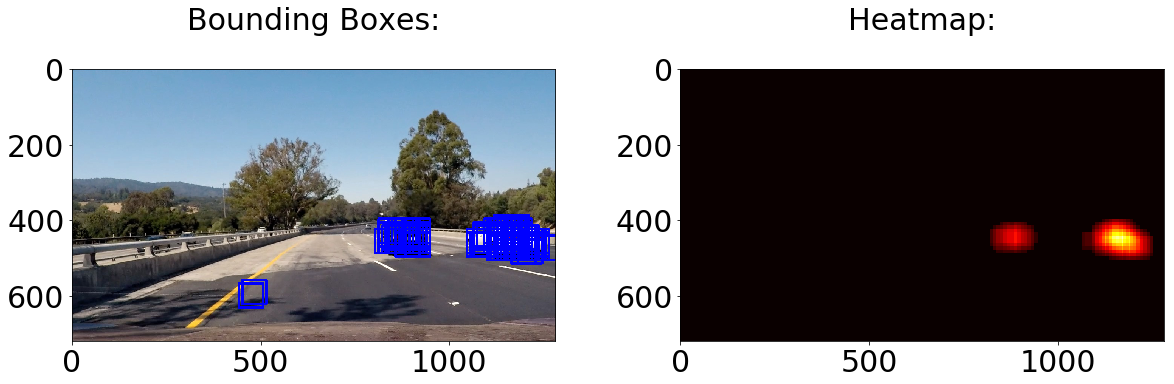

In [28]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap
 
def apply_heat_threshold(heatmap, threshold=4):
    heatmap[heatmap <= threshold] = 0
    return heatmap

bbdict = pickle.load( open( "bbox_pickle.p", "rb" ))
all_bboxes = bbox_pickle["bboxes"]

img = mpimg.imread('test_images/test4.jpg')
#img = undistort(img)
heatmap = np.zeros_like(img[:,:,0].astype(np.float))

heatmap = add_heat(heatmap, all_bboxes)
heatmap = apply_heat_threshold(heatmap)
heatmap = np.clip(heatmap-2, 0, 255)

labels = label(heatmap)

#print('Cars Found: {0}'.format(labels[1]))

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=30) 
matplotlib.rc('ytick', labelsize=30)

plt.subplot(1, 2, 1)
plt.imshow(window_img)
plt.title('Bounding Boxes:\n', fontsize=30);
plt.subplot(1, 2, 2)
plt.imshow(heatmap, cmap='hot')
plt.title('Heatmap:\n', fontsize=30);
plt.savefig('output_images/heatmap.png')

##### Estimate a bounding box for vehicles detected.

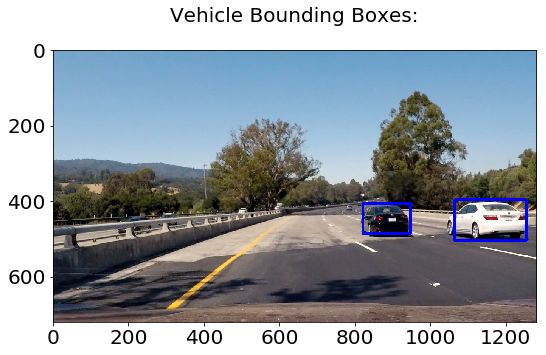

In [29]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

img = mpimg.imread('test_images/test4.jpg')
draw_img = np.copy(img)
draw_img = draw_labeled_bboxes(draw_img, labels)

f = plt.figure(figsize=(20, 5))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
plt.imshow(draw_img)
plt.title('Vehicle Bounding Boxes:\n', fontsize=20);

##### Output results as a video.

In [30]:
def BGRtoYUV(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

orientations = 8
pixels_per_cell = 8
cells_per_block = 2

def hog_features(channel, visualise=False):
    if visualise == True:
        features, hog_image = hog(channel, orientations=orientations,
                                  pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                                  cells_per_block=(cells_per_block, cells_per_block),
                                  transform_sqrt=False, visualise=True, feature_vector=False)
        return hog_image
    else:      
        features = hog(channel, orientations=orientations,
                       pixels_per_cell=(pixels_per_cell, pixels_per_cell),
                       cells_per_block=(cells_per_block, cells_per_block),
                       transform_sqrt=False, visualise=False, feature_vector=True)
        return features

def derive_features(img):
    img = BGRtoYUV(img)
    features_y = hog_features(img[:,:,0])
    features_u = hog_features(img[:,:,1])
    features_v = hog_features(img[:,:,2])
    return np.concatenate((features_y, features_u, features_v))

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

In [31]:
input_images = []
y = []

for filename in tqdm(glob.glob('datasets/vehicles/*/*.png')):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(True)

for filename in tqdm(glob.glob('datasets/non-vehicles/*/*.png')):
    img = cv2.imread(filename)
    features = derive_features(img)
    input_images.append(features)
    y.append(False)

100%|██████████| 8968/8968 [00:25<00:00, 358.09it/s]


In [32]:
X_scaler = StandardScaler().fit(input_images)
input_images = X_scaler.transform(input_images)

X_train, X_test, y_train, y_test = train_test_split(input_images, y, test_size=0.2, stratify=y, random_state=1)

classifier = LinearSVC(random_state=1)
classifier.fit(X_train, y_train)

print('Vehicle classifier trained with test accuracy: %.1f%%' % (100. * classifier.score(X_test, y_test)))

Vehicle classifier trained with test accuracy: 98.5%


In [33]:
WINDOW_SIZES = [(64, 64), (96, 96), (128, 128)]
WINDOW_Y_START_STOP = [(400, 500), (400, 500), (400, 500)]
WINDOW_OVERLAP = (0.8, 0.8)

# img is of RGB type
def slide_window(img):
    window_list = []
    
    for (xy_window, y_start_stop) in zip(WINDOW_SIZES, WINDOW_Y_START_STOP):
        x_start = int(img.shape[1]/2)
        x_stop = img.shape[1]
        y_start = y_start_stop[0]
        y_stop = y_start_stop[1]
    
        # Compute ROI.
        xspan = x_stop - x_start
        yspan = y_stop - y_start
        
        # Compute the step between successive windows.
        nx_pix_per_step = np.int(xy_window[0] * (1. - WINDOW_OVERLAP[0]))
        ny_pix_per_step = np.int(xy_window[1] * (1. - WINDOW_OVERLAP[1]))
        # Compute the number of windows to generate at this size.
        nx_windows = int(xspan/nx_pix_per_step) - 1
        ny_windows = int(yspan/ny_pix_per_step) - 1
        # Loop through the x and y positions to find the window coordinates.
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                startx = xs*nx_pix_per_step + x_start
                endx = startx + xy_window[0]
                starty = ys*nx_pix_per_step + y_start
                endy = starty + xy_window[1]
                window_list.append(((startx, starty), (endx, endy)))
                
    # Return the list of windows.
    return window_list

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
img = draw_boxes(img, windows)

In [34]:
threshold = 0.8

def search_windows(img, windows, clf, scaler):
    # Create a list to hold the positive detections.
    on_windows = []
    
    # Iterate over all the windows in the list.
    for window in windows:
        # Extract the window image from the original image.
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # Convert to the expected BGR in feature extractor.
        window_img = cv2.cvtColor(window_img, cv2.COLOR_RGB2BGR)
        # Extract features for the resized window image
        features = derive_features(window_img)
        # Normalize the extracted features.
        features = scaler.transform(np.array(features).reshape(1, -1))
        # Save the window if prediction is positive.
        if clf.decision_function(features) > threshold:
            on_windows.append(window)
    
    # Return the windows with positive detections.
    return on_windows

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
img = draw_boxes(img, windows)

In [35]:
HEATMAP_THRESHOLD = 4

def add_heat(heatmap, bboxes):
    # Iterate through each bbox.
    for bbox in bboxes:
        # Add +1 for all pixels inside each bbox.
        heatmap[bbox[0][1]:bbox[1][1], bbox[0][0]:bbox[1][0]] += 1
    # Return updated heatmap.
    return heatmap
    
def apply_threshold(heatmap):
    # Zero out pixels below the threshold.
    heatmap[heatmap <= HEATMAP_THRESHOLD] = 0
    # Return thresholded map.
    return heatmap

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)

In [36]:
def draw_labeled_bboxes(img, heatmap):
    # Generate the labels from the heat map.
    labels = label(heatmap)
    # Keep a list of bboxes for detected vehicles.
    bboxes = []
    # Iterate through all detected vehicles.
    for vehicle in range(1, labels[1]+1):
        # Find pixels with each vehicle label value.
        nonzero = (labels[0] == vehicle).nonzero()
        # Identify x and y values of those pixels.
        nonzerox = np.array(nonzero[0])
        nonzeroy = np.array(nonzero[1])
        # Define a bounding box based on the min/max x and y.
        bbox = ((np.min(nonzeroy), np.min(nonzerox)), (np.max(nonzeroy), np.max(nonzerox)))
        bboxes.append(bbox)
    # Draw the bounding boxes for the detected vehicles.
    img = draw_boxes(img, bboxes)
    # Return the annotated image.
    return img

img = cv2.imread('test_images/test4.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
windows = slide_window(img)
windows = search_windows(img, windows, classifier, X_scaler)
heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, windows)
heatmap = apply_threshold(heatmap)
img = draw_labeled_bboxes(img, heatmap)

In [37]:
frame_count = 5

class VehicleDetector:
    def __init__(self):
        self.bboxes = []
    
    def add_bboxes(self, bboxes):
        self.bboxes.append(bboxes)
        self.bboxes = self.bboxes[-frame_count:]
    
    def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for bboxes in self.bboxes:
            add_heat(heatmap, bboxes)
        heatmap = apply_threshold(heatmap)
        return heatmap

In [38]:
def video_pipeline(img, vehicle_detector=None):
    if vehicle_detector is None:
        vehicle_detector = VehicleDetector()
    windows = slide_window(img)
    windows = search_windows(img, windows, classifier, X_scaler)
    vehicle_detector.add_bboxes(windows)
    heatmap = vehicle_detector.heatmap()
    img = draw_labeled_bboxes(img, heatmap)
    return img

In [39]:
video_output = 'output_images/test_video.mp4'
clip = VideoFileClip('test_videos/test_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/test_video.mp4
[MoviePy] Writing video output_images/test_video.mp4


 97%|█████████▋| 38/39 [00:52<00:01,  1.39s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_video.mp4 

CPU times: user 52.5 s, sys: 227 ms, total: 52.7 s
Wall time: 53.5 s


In [40]:
video_output = 'output_images/project_video_final.mp4'
clip = VideoFileClip('test_videos/project_video.mp4')

output_clip = clip.fl_image(video_pipeline) #color images only
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_final.mp4
[MoviePy] Writing video output_images/project_video_final.mp4


100%|█████████▉| 1260/1261 [27:52<00:01,  1.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_final.mp4 

CPU times: user 27min 45s, sys: 6.16 s, total: 27min 51s
Wall time: 27min 52s
